# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile
import numpy as np
import io
import inspect

from PIL import Image, ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import json 

# loading some stuff
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
font = ImageFont.truetype(r'AGFOR26.TTF',20)

# getting started
smallFile = zipfile.ZipFile('readonly/small_img.zip') # a-0.png thru a-3
largeFile = zipfile.ZipFile('readonly/images.zip') # a-0.png thru a-13

# file handle abstraction for testing
pwf = smallFile
test_image = Image.open('readonly/text.png')

In [2]:
def zip_to_dict(thezipfile):
    '''
    :param:(str) path to a zip file
    
    :returns:(dict) a dictionary initialized with a key for each file in the zip file, 
      a value for each key of a subdictionary, 
      within the subdictionary, a key ('im') value (PIL.Image object) pair
      
    An example return:
    
    {   "a-0.png": {
            "im": "<PIL.PngImagePlugin.PngImageFile ...>"
        },
        "a-1.png": {
            "im": "<PIL.PngImagePlugin.PngImageFile ...>"
        }
    }
      
    '''
    
    dictionary={}
    for obj in thezipfile.infolist():  # ordered; of type: <ZipInfo filename='a-0.png' compress_type=deflate external_attr=0x20 file_size=21000053 compress_size=20835185>
        dictionary[obj.filename] = {}
        raw_data = thezipfile.read(obj)    # of type: bytes
        #print(type(raw_data))
        pretty_bytes = io.BytesIO(raw_data)
        #print(type(pretty_bytes))
        im = Image.open(pretty_bytes) # makes a PIL.Image-object out of the IOBytes-object
        dictionary[obj.filename]['im'] = im      
    return dictionary


# show the structure of the dictionary
# test = zip_to_dict(pwf)
# print(json.dumps( test , indent=4, default=str))

In [3]:
# use tesseract to build a list of words in the image
    
def bin_read_search(image, target):
    '''
    :params: PIL.Image object, string to look for
    :returns: a boolean of the search result
    '''

    bin_img = image.convert('1')
    
    text = pytesseract.image_to_string(bin_img)    
    text = text.replace('\n','')
            
    return target.lower() in text.lower()

#bin_read_search(Image.open('readonly/Noisy_OCR.PNG'), 'Behold') 
#bin_read_search(test['a-0.png']['im'], 'Christopher')

In [4]:
def find_face_boxes(PILimage):
    '''
    takes an image, finds the faces on it (if any), and returns a list of coordinate-tuples that bound the faces found
    
    :param: a PIL.Image object
    
    :returns: a list, containing 4-tuples
    '''
    
    imgarr = np.array(PILimage)
    gray = cv.cvtColor(imgarr, cv.COLOR_BGR2GRAY)
    #binarized = cv.threshold(imgarr,120,255,cv.THRESH_BINARY)[1] # returns a list, we want the second value
    coords_list = face_cascade.detectMultiScale(gray, scaleFactor =1.3, minNeighbors = 5).tolist()
    
    faces_list = []
    if len(coords_list) > 0:     # if there's at least one face, continue
        drawing = ImageDraw.Draw(PILimage)
        for (x,y,w,h) in coords_list:
            #drawing.rectangle((x,y,x+w,y+h), outline="red")
            #display(PILimage)
            faces_list.append((x,y,x+w,y+h))
    
    return faces_list

#test = zip_to_dict(largeFile)
#first_img = test['a-9.png']['im']
#find_face_boxes(first_img)

In [5]:
# populate a list with images
def contact_sheet(list_of_PIL_images, sq_size=72):
    '''
    builds and displays a sheet for a nonzero number of faces
    '''
    
    #if type(list_of_PIL_images) != str: 
       # return 'contact sheet here :)'
    
    nrows = int(len(list_of_PIL_images)/5) # set up for 5 (columns) per row
    contact_sht = Image.new(list_of_PIL_images[0].mode, (sq_size*5, sq_size*(nrows+1)))
    
    (x,y) = (0,0)
    for img in list_of_PIL_images:
        # paste in an image from the list
        img.thumbnail((sq_size,sq_size))
        contact_sht.paste(img, (x, y))
    
        # Now we update our coordinate position. If our x-position is going to be at the right-edge of the image, then we set it back to 0 (and update y as well) to point to the next "line" of the contact sheet.
        if x+sq_size == contact_sht.width:
            x = 0
            y = y+sq_size
        else:
            x = x+sq_size
      
    
    #contact_sht = contact_sht.resize((int(contact_sht.width/3),int(contact_sht.height/3) ))
    return contact_sht

#contact_sheet([Image.open('readonly/floyd.jpg'), Image.open('readonly/Noisy_OCR.PNG')])

In [6]:
def run(thezipfile=smallFile, theword='Christopher'):
    '''
    the overarching logic
    '''
    
    # initialize the dictionary of file entries
    d = zip_to_dict(thezipfile)
    
    for ky in d:
    #for ky in list(d.keys())[:1]:        # uses only one file for testing
        PILimage = d[ky]['im']
        
        # Look for the word. 
        word_search_result = bin_read_search( PILimage, theword )  # returns a boolean of the word search's success
        if not word_search_result: continue
        
        # The target word is in the file...
        print('Results found in file {}'.format(ky))
        
        # ... so look for faces.
        try:
            faces_coords_list = find_face_boxes(PILimage)
        except:
            faces_coords_list = []   # I don't know if this try/except is necessary. What happens with find_face_boxes() when it doesn't find anything??
        
        # If there are no faces... make and store that face-search-result-image, and continue to the next file
        if len(faces_coords_list) < 1:  #there could be a failure here. Again the question: what exactly does find_face_boxes() return?
            print('But there were no faces in that file!')
            continue
        
        # So there is a face! Crop it/them, and store face-search-result in the dictionary
        face_pics_list = []
        for (x1,y1,x2,y2) in faces_coords_list:
            facePIL = PILimage.crop((x1,y1,x2,y2))
            face_pics_list.append(facePIL)
        display(contact_sheet(face_pics_list))
        
        
    #Let's take a look: pretty print (as strings) the dictionary contents 
    print(json.dumps( d , indent=4, default=str))

Results found in file a-0.png


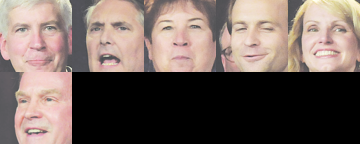

Results found in file a-3.png


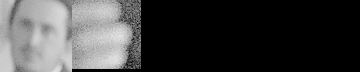

{
    "a-0.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3600x6300 at 0x7FF7C156C668>"
    },
    "a-1.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3600x6300 at 0x7FF7C156C6D8>"
    },
    "a-2.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3600x6300 at 0x7FF7C156C518>"
    },
    "a-3.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=7200x6300 at 0x7FF7C156C358>"
    }
}


In [7]:
run(smallFile, 'Christopher')

Results found in file a-0.png


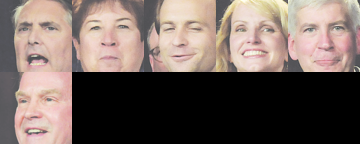

Results found in file a-1.png


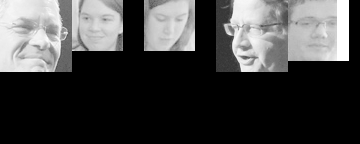

Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png


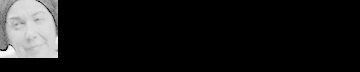

Results found in file a-2.png


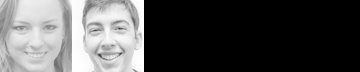

Results found in file a-3.png


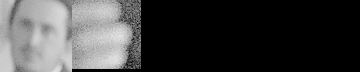

Results found in file a-5.png


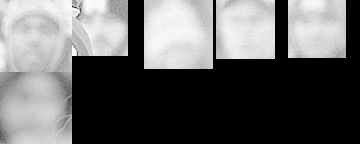

Results found in file a-8.png
But there were no faces in that file!
Results found in file a-9.png


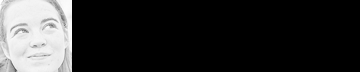

{
    "a-0.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3600x6300 at 0x7FF7C156CEB8>"
    },
    "a-1.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3600x6300 at 0x7FF7C156CDD8>"
    },
    "a-10.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=6300x3600 at 0x7FF7C158E6A0>"
    },
    "a-11.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3150x3600 at 0x7FF7C158E5C0>"
    },
    "a-12.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3150x3600 at 0x7FF7C158E780>"
    },
    "a-13.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3150x3600 at 0x7FF7C158E7F0>"
    },
    "a-2.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3600x6300 at 0x7FF7C158E860>"
    },
    "a-3.png": {
        "im": "<PIL.PngImagePlugin.PngImageFile image mode=RGB size=7200x6300 at 0x7FF7C158E8D0>"
    },
    "a-4.png": {
 

In [8]:
run(largeFile,'Mark')

In [9]:
# goodbye
#smallFile.close()
#largeFile.close()